In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import pandas as pd
import os
import sys
import datetime

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    
load_dotenv()

True

In [2]:
import tensorflow as tf
tf.__version__, tf.config.list_physical_devices('GPU')

('2.10.1', [])

In [3]:
from utils.utils import date_range, preprocess_b

df_train = pd.concat([
    pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2019, 11, 1), 
        datetime.date(2020, 2, 1),
        datetime.timedelta(days=1),
    )
])
df_val = pd.concat([
    pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2020, 2, 1), 
        datetime.date(2020, 2, 15),
        datetime.timedelta(days=1),
    )
])

X_train, y_train = preprocess_b(df_train)
X_val, y_val = preprocess_b(df_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1598125, 24), (1598125, 3), (263845, 24), (263845, 3))

In [4]:
from keras.models import Sequential, clone_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

prev_days = int(os.getenv('PREV_DAYS'))


model = Sequential()
model.add(InputLayer((3 + 3 * prev_days, 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation=LeakyReLU(alpha=0.01)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            256       
                                                                 
 flatten (Flatten)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 8)                 11272     
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 11,537
Trainable params: 11,537
Non-trainable params: 0
_________________________________________________________________


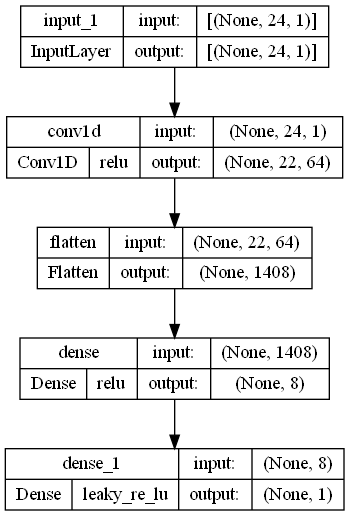

In [5]:
# plot model
from keras.utils import plot_model

plot_model(model,to_file='../.data/model_b.png', show_layer_activations=True, show_shapes=True, show_layer_names=True)

In [6]:
model_view = clone_model(model)
cp_view = ModelCheckpoint('../model/b-view.keras', save_best_only=True)
model_view.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_view.fit(X_train, y_train[:, 0], validation_data=(X_val, y_val[:, 0]), epochs=10, callbacks=[cp_view])

Epoch 1/10
49942/49942 [==============================] - 109s 2ms/step - loss: 1.3860e-06 - root_mean_squared_error: 0.0012 - val_loss: 6.3835e-06 - val_root_mean_squared_error: 0.0025
Epoch 2/10
49942/49942 [==============================] - 78s 2ms/step - loss: 1.1627e-06 - root_mean_squared_error: 0.0011 - val_loss: 6.2689e-06 - val_root_mean_squared_error: 0.0025
Epoch 3/10
49942/49942 [==============================] - 80s 2ms/step - loss: 1.1231e-06 - root_mean_squared_error: 0.0011 - val_loss: 6.2331e-06 - val_root_mean_squared_error: 0.0025
Epoch 4/10
49942/49942 [==============================] - 77s 2ms/step - loss: 1.1130e-06 - root_mean_squared_error: 0.0011 - val_loss: 6.1231e-06 - val_root_mean_squared_error: 0.0025
Epoch 5/10
49942/49942 [==============================] - 80s 2ms/step - loss: 1.0939e-06 - root_mean_squared_error: 0.0010 - val_loss: 6.1627e-06 - val_root_mean_squared_error: 0.0025
Epoch 6/10
49942/49942 [==============================] - 95s 2ms/step - l

In [7]:

model_cart = clone_model(model)
cp_cart = ModelCheckpoint('../model/b-cart.keras', save_best_only=True)
model_cart.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_cart.fit(X_train, y_train[:, 1], validation_data=(X_val, y_val[:, 1]), epochs=10, callbacks=[cp_cart])

Epoch 1/10
49942/49942 [==============================] - 79s 2ms/step - loss: 8.5171e-06 - root_mean_squared_error: 0.0029 - val_loss: 1.0600e-05 - val_root_mean_squared_error: 0.0033
Epoch 2/10
49942/49942 [==============================] - 74s 1ms/step - loss: 8.0565e-06 - root_mean_squared_error: 0.0028 - val_loss: 1.1834e-05 - val_root_mean_squared_error: 0.0034
Epoch 3/10
49942/49942 [==============================] - 85s 2ms/step - loss: 7.9899e-06 - root_mean_squared_error: 0.0028 - val_loss: 1.1336e-05 - val_root_mean_squared_error: 0.0034
Epoch 4/10
49942/49942 [==============================] - 94s 2ms/step - loss: 7.9079e-06 - root_mean_squared_error: 0.0028 - val_loss: 1.0986e-05 - val_root_mean_squared_error: 0.0033
Epoch 5/10
49942/49942 [==============================] - 83s 2ms/step - loss: 7.8250e-06 - root_mean_squared_error: 0.0028 - val_loss: 1.0744e-05 - val_root_mean_squared_error: 0.0033
Epoch 6/10
49942/49942 [==============================] - 85s 2ms/step - lo

In [9]:

model_purchase = clone_model(model)
cp_purchase = ModelCheckpoint('../model/b-purchase.keras', save_best_only=True)
model_purchase.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_purchase.fit(X_train, y_train[:, 2], validation_data=(X_val, y_val[:, 2]), epochs=10, callbacks=[cp_purchase])

Epoch 1/10
49942/49942 [==============================] - 100s 2ms/step - loss: 3.2601e-05 - root_mean_squared_error: 0.0057 - val_loss: 2.7774e-05 - val_root_mean_squared_error: 0.0053
Epoch 2/10
49942/49942 [==============================] - 94s 2ms/step - loss: 3.1471e-05 - root_mean_squared_error: 0.0056 - val_loss: 2.4035e-05 - val_root_mean_squared_error: 0.0049
Epoch 3/10
49942/49942 [==============================] - 97s 2ms/step - loss: 3.1092e-05 - root_mean_squared_error: 0.0056 - val_loss: 2.4684e-05 - val_root_mean_squared_error: 0.0050
Epoch 4/10
49942/49942 [==============================] - 98s 2ms/step - loss: 3.0935e-05 - root_mean_squared_error: 0.0056 - val_loss: 2.5183e-05 - val_root_mean_squared_error: 0.0050
Epoch 5/10
49942/49942 [==============================] - 107s 2ms/step - loss: 3.0711e-05 - root_mean_squared_error: 0.0055 - val_loss: 2.5293e-05 - val_root_mean_squared_error: 0.0050
Epoch 6/10
49942/49942 [==============================] - 103s 2ms/step -